# Implementasi Metode Deep Learning untuk Deteksi Malware menggunakan Arsitektur CNN dengan Hyperparameter Tuning

Sub Sistem ini bertujuan untuk membangun **Convolutional Neural Network** model untuk melakukan klasifikasi **Classification Biner Malwares** dari dataset yang berhasil di generate di bagian sub sistem sebelumnya. Pada Sub Sistem ini untuk melatih model maka digunakan **Dataset Hasil Subsistem Generating Image Malware**.

Tahapan Sub-Sistem | Testing Image Dataset Image Malware:
1. Preprocessing & Understanding Data - Generate the dataset
2. Data Visualization
3. Analyse Data 
4. Model Building
5. Model Evaluation


## Deskripsi Data : 
Dataset yang akan digunakan bersumber dari output subsistem generating image malware yang di simpan didalam google drive. Dataset berisikan malware dengan format png, sampel malware terbagi menjadi 2 kelas yaitu benign (jinak) dan malicious(berbahaya). Kelas ini disimpan didalam 2 folder yang dibedakan berdasarkan kode warnanya yaitu grayscale dan RGB. Total sampel malware yang memiliki kode grayscale adalah 1905 (872 benign, 1033 malicious) dan toal sampel malware yang memiliki kode RGB adalah 1883 (858 benign, 1025). Adapun jenis kelas malware yang digunakan berasal dari 2 kelas besar yaitu Trojan, Backdoor, Worm, dan Ransomware. 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.Preprocessing - Load dataset dari Direktori

Folder Path Dataset :

In [ ]:
path_root = "/content/drive/MyDrive/Tugas Akhir | Membangun Database Malware/Dataset/RGB"

Dataset yang digunakan adalah Dataset Original dengan ukuran 2 Gb. Dataset berisikan malware dengan format png. Malware terdistribusi menjadi 2 kelas dengan total jumlah sampel malware untuk kode grayscale adalah 1905 (872 benign, 1033 malicious) dankode RGB adalah 1883 (858 benign, 1025).  gambar malware

Agar dapat menggunakan image malware untuk training dan testing, maka digunakan **ImageDataGenerator.flow_from_directory()** yang akan menghasilkan kumpulan data gambar yang dinormalisasi dari masing-masing direktori data.
  * **target_size** : Akan merubah ukuran semua gambar menjadi ukuran target (128*128).
  * **batch_size** : Ukuran batch yang akan digunakan. Pada kasus ini, jumlah gambar adalah 1883, maka batch_size yang disetel minimal sejumlah sampel gambar

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
batches = ImageDataGenerator().flow_from_directory(directory=path_root, target_size=(128,128), batch_size=2000)

Found 1883 images belonging to 2 classes.


Dapat diamati bahwa terdapat 2 kelas malwaare. Kemudian kelas akan diperjelas dengan menggunakan kamus berupa key:value untuk setiap kelas.

In [ ]:
batches.class_indices

{'Benign': 0, 'Malicious': 1}

**batches** yang dihasilkan dari ImageDataGenerator() adalah sebuah iterator. Oleh karena itu, digunakan next() untuk menelusuri semua elemen gambar dan menghasilkan sekumpulan gambar dan label dari kumpulan dataset.

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
imgs, labels = next(batches)

Dapat diamati, gambar dalam grayscale dengan bentuk 128x128 [width x length x depth].

In [ ]:
imgs.shape

(1883, 128, 128, 3)

**labels** memiliki shape (batch_size, number of classes atau jumlah kelas).

In [ ]:
labels.shape

(1883, 2)

## 2.Visualisasi Data

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# Plotting sampel malware
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 6 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,30):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

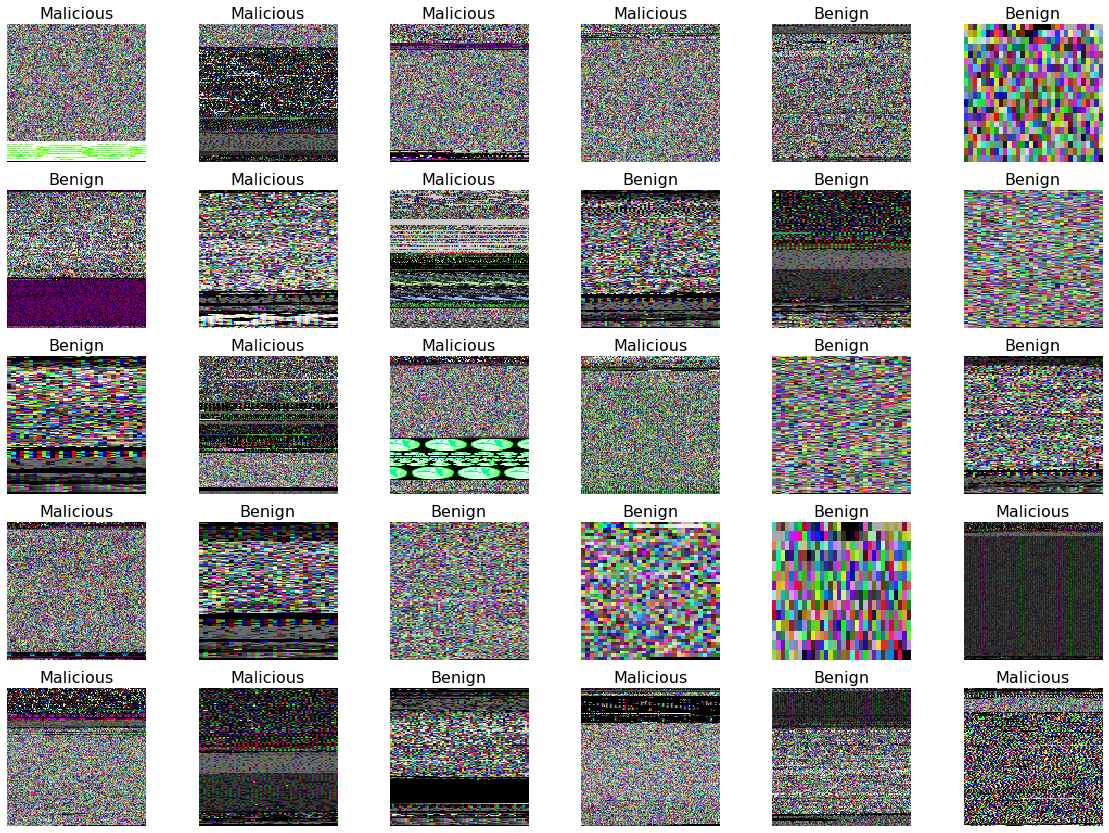

In [ ]:
plots(imgs, titles = labels)

Dari gambar diatas dapat diamati perbedaan antar kelas.

## 3.Analisis Data

### **a) Distribution Data**

Cek Distribusi data Malware antar kelas:

In [ ]:
classes = batches.class_indices.keys()

In [ ]:
perc = (sum(labels)/labels.shape[0])*100

<BarContainer object of 2 artists>

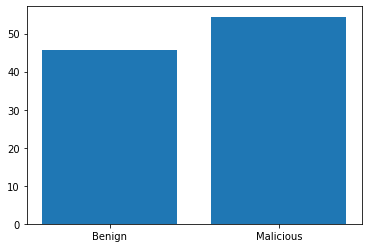

In [ ]:
plt.xticks(rotation='horizontal')
plt.bar(classes,perc)

Dapat diamati bahwa dataset malware cukup seimbang (balanced), distribusi data terbanyak pada kelas 1 (Malicious) kemudian diikuti oleh kelas 0 (Benign)

### **b) Training, Validation, Testing Split**

Dataset Model akan dipisahkan menjadi training dan testing dengan rasio 70% training - 30% testing.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.3)

In [ ]:
X_train.shape

(1318, 128, 128, 3)

In [ ]:
X_test.shape

(565, 128, 128, 3)

In [ ]:
y_train.shape

(1318, 2)

In [ ]:
y_test.shape

(565, 2)

## **4. Model Building**

### **a) Building Model Architecture**

#### Convolutional Neural Network Model

Model yang akan dibangun adalah CNN menggunakan Keras. Model ini akan memiliki lapisan sebagai berikut:


* **Convolutional Layer** : 16 filter, ukuran kernel (3 * 3)
* **Max Pooling Layer** :  ukuran Max Pooling (2 * 2)
* **Convolutional Layer** : 32 filter, ukuran kernel (3 * 3) 
* **Max Pooling Layer** : ukuran Max Pooling (2 * 2)
* **Convolutional Layer** : 64 filter, ukuran kernel (3 * 3) 
* **Max Pooling Layer** : ukuran Max Pooling (2 * 2)
* **Convolutional Layer** : 128 filter, ukuran kernel (3 * 3) 
* **Max Pooling Layer** : ukuran Max Pooling (2 * 2)

* **Flatten Layer**
* **Dense/Fully Connected Layer** : 256 Neuron, fungsi aktivasi Relu
* **Dense/Fully Connected Layer** : 512 Neuron, fungsi aktivasi Softmax
* **Dense/Fully Connected Layer** : num_class Neuron, fungsi aktivasi Sigmoid

**Input Shape** : 128 * 128 * 3

In [ ]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization

In [ ]:
import tensorflow as tf

Tetapkan sebanyak 2 kelas sebagai output.

In [ ]:
num_classes = 2

Building the model

In [ ]:
def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(16, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(128,128,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(32, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(64, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(128, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
   
    Malware_model.add(Flatten())
    Malware_model.add(Dense(256, activation='relu'))
    Malware_model.add(Dense(512, activation='relu'))
    Malware_model.add(Dense(num_classes, activation='sigmoid'))
    Malware_model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return Malware_model

In [ ]:
Malware_model = malware_model()

In [ ]:
Malware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

### **b) Trainig the Model**

In [ ]:

import time
start = time.time()
histroy1 = Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)
stop = time.time()
print(f"Training time: {stop - start}s")


Epoch 1/50
42/42 [==============================] - 24s 531ms/step - loss: 0.6639 - accuracy: 0.6070 - val_loss: 1.2380 - val_accuracy: 0.4478
Epoch 2/50
42/42 [==============================] - 21s 489ms/step - loss: 0.6082 - accuracy: 0.7033 - val_loss: 0.4420 - val_accuracy: 0.8389
Epoch 3/50
42/42 [==============================] - 21s 494ms/step - loss: 0.4687 - accuracy: 0.7959 - val_loss: 0.4206 - val_accuracy: 0.8142
Epoch 4/50
42/42 [==============================] - 21s 493ms/step - loss: 0.4292 - accuracy: 0.8225 - val_loss: 0.4746 - val_accuracy: 0.7540
Epoch 5/50
42/42 [==============================] - 21s 495ms/step - loss: 0.4047 - accuracy: 0.8255 - val_loss: 0.4292 - val_accuracy: 0.8549
Epoch 6/50
42/42 [==============================] - 23s 561ms/step - loss: 0.3856 - accuracy: 0.8331 - val_loss: 0.3912 - val_accuracy: 0.8407
Epoch 7/50
42/42 [==============================] - 21s 495ms/step - loss: 0.3359 - accuracy: 0.8695 - val_loss: 0.3791 - val_accuracy: 0.8265

## **5. Model Evaluation**

### **a) Akurasi dan Loss Model**

In [ ]:
scores = Malware_model.evaluate(X_test, y_test)

18/18 [==============================] - 2s 126ms/step - loss: 1.3078 - accuracy: 0.8867


### **b) Plot grafik train vs validation**

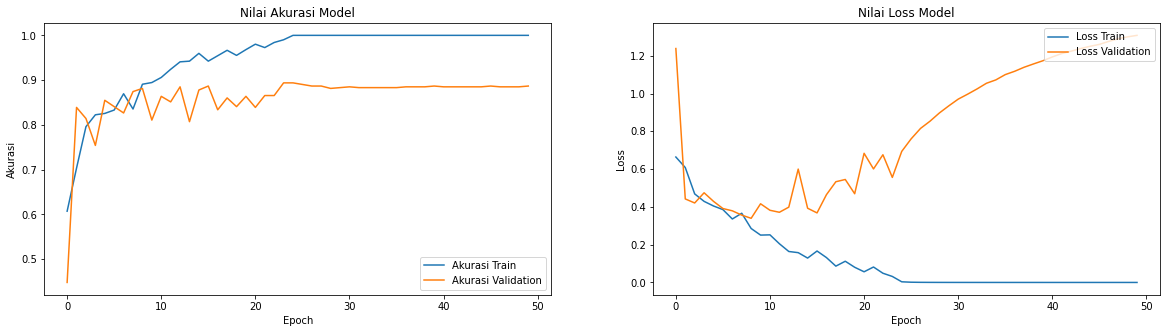

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20,5))

ax[0].plot(histroy1.history['accuracy'])
ax[0].plot(histroy1.history['val_accuracy'])
ax[0].set_title('Nilai Akurasi Model')
ax[0].set_ylabel('Akurasi')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Akurasi Train', 'Akurasi Validation'], loc='lower right')

ax[1].plot(histroy1.history['loss'])
ax[1].plot(histroy1.history['val_loss'])
ax[1].set_title('Nilai Loss Model')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Loss Train', 'Loss Validation'], loc='upper right')

plt.show()

akurasi yang didapatkan untuk 50 Epoch adalah 90 % 

In [ ]:
print('Final CNN accuracy: ', scores[1])

Final CNN accuracy:  0.886725664138794


###**c) Classification Report**

Dilakukan analisis dari Classification Report dan Confusion Matrix

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
y_pred=np.argmax(Malware_model.predict(X_test), axis=-1)

In [ ]:
y_pred

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,

In [ ]:
y_test2 = np.argmax(y_test, axis=1)

In [ ]:
y_test2

array([1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,

In [ ]:
from sklearn.metrics import classification_report


print("***************** CLASSIFICATION REPORT  *****************")
print(classification_report(y_test2,y_pred),"\n\n")

***************** CLASSIFICATION REPORT  *****************
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       250
           1       0.90      0.89      0.90       315

    accuracy                           0.89       565
   macro avg       0.88      0.89      0.89       565
weighted avg       0.89      0.89      0.89       565
 




###**d) Nilai akurasi, presisi, recall, loss, dan F1-Score**

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test2,y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test2,y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test2,y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test2,y_pred)
print('F1 score: %f' % f1)

Accuracy: 0.886726
Precision: 0.903537
Recall: 0.892063
F1 score: 0.897764


###**e) Confusion Matrix**

In [ ]:
from sklearn import metrics
c_matrix = metrics.confusion_matrix(y_test2, y_pred)

In [ ]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

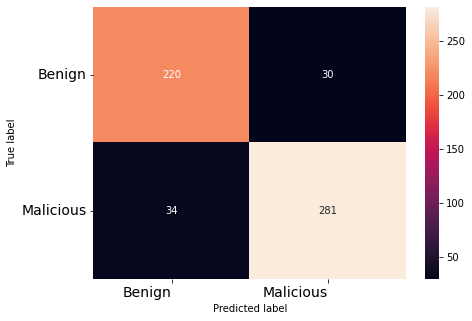

In [ ]:
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (7,5), fontsize=14)

###**f) Testing Dataset Image Malware**

In [ ]:
import numpy as np
from fractions import Fraction

#### Deteksi Kelas Malicious

1
Ini adalah Malicious


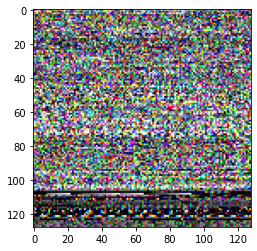

In [ ]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt



data = '/content/drive/MyDrive/Tugas Akhir | Membangun Database Malware/Dataset/RGB/Malicious/0017e2bb45469ea5f02edab017f77b7242c9a3330478c748e7e8380149ded601_RGB.png'

img = image.load_img(data, target_size=(128, 128))
imgplot = plt.imshow(img)

x = image.img_to_array(img)
x = x.reshape(1, 128, 128, 3)
x = x/255
prediksi=np.argmax(Malware_model.predict(x))
# prediksi = Malware_model.predict(x)
# prediksi=e(-prediksi)
# x = np.array([0.1, 0.2], dtype=object)
# >>> np.exp(x)

print(prediksi)
if prediksi==1:
  print('Ini adalah Malicious')
else:
  print('Ini adalah Benign')

#### Deteksi Kelas Benign

0
Ini adalah Benign


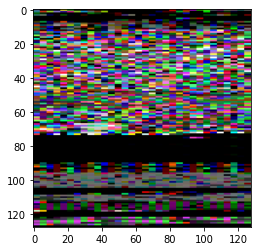

In [ ]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt



data = '/content/drive/MyDrive/Tugas Akhir | Membangun Database Malware/Dataset/RGB/Benign/ARP_RGB.png'

img = image.load_img(data, target_size=(128, 128))
imgplot = plt.imshow(img)

x = image.img_to_array(img)
x = x.reshape(1, 128, 128, 3)
x = x/255
prediksi=np.argmax(Malware_model.predict(x))
# prediksi = Malware_model.predict(x)
# prediksi=e(-prediksi)
# x = np.array([0.1, 0.2], dtype=object)
# >>> np.exp(x)

print(prediksi)
if prediksi==1:
  print('Ini adalah Malicious')
else:
  print('Ini adalah Benign')

In [ ]:
Malware_model.save('Tugas Akhir | Membangun Database Malware/model_malicious_benign.h5')